# Q4 Variational Autoencoder (VAE) 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import hashlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import imageio
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        0.97, 0.97, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


In [3]:
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("GPU not available. Using CPU.")
    device = torch.device("cpu")

torch.manual_seed(seed)

PyTorch version: 2.5.1+cu121
GPU is available!
Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## 4.2 Dataset Preparation

In [4]:
class FashionMNISTDataModule:
    """
    Handles loading and preprocessing of the Fashion-MNIST dataset.
    """
    def __init__(self, batch_size=64, data_dir='./Dataset/Q4/'):
        """
        Initialize the DataModule.

        Args:
            batch_size (int): Size of batches for the DataLoader.
            data_dir (str): Directory to store/load the dataset.
        """
        self.batch_size = batch_size
        self.data_dir = data_dir
        
        # Define transformations. 
        # We use ToTensor() to scale images to [0, 1] for compatibility with BCE Loss.
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def get_dataloaders(self):
        """
        Downloads (if needed) and creates DataLoaders for training and testing.

        Returns:
            train_loader (DataLoader): DataLoader for training set.
            test_loader (DataLoader): DataLoader for test set.
        """
        # Download and load training data
        train_dataset = datasets.FashionMNIST(
            root=self.data_dir, 
            train=True, 
            transform=self.transform, 
            download=True
        )

        # Download and load test data
        test_dataset = datasets.FashionMNIST(
            root=self.data_dir, 
            train=False, 
            transform=self.transform, 
            download=True
        )

        # Create DataLoaders
        train_loader = DataLoader(
            dataset=train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True
        )
        
        test_loader = DataLoader(
            dataset=test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False
        )
        
        return train_loader, test_loader

In [5]:
data_module = FashionMNISTDataModule(batch_size=128)
train_loader, test_loader = data_module.get_dataloaders()
print("Dataset prepared successfully.")

Dataset prepared successfully.


## 4.3 Model Architecture

In [6]:
class Encoder(nn.Module):
    """
    Encoder network mapping input to latent mean and log-variance.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Output layers for mean (mu) and log-variance (logvar)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    """
    Decoder network reconstructing images from latent samples.
    """
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        # Sigmoid activation to map outputs to [0, 1] for BCE Loss
        reconstruction = torch.sigmoid(self.linear3(z))
        return reconstruction

class VAE(nn.Module):
    """
    Variational Autoencoder combining Encoder and Decoder with Reparameterization.
    """
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        
    def reparameterize(self, mu, logvar):
        """
        Reparameterization Trick: z = mu + epsilon * sigma
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(std)
            return mu + epsilon * std
        else:
            # During inference/testing, we just return the mean
            return mu
    
    def forward(self, x):
        # Flatten input [Batch, 1, 28, 28] -> [Batch, 784]
        x = x.view(-1, 784)
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

### Test a model

In [ ]:
input_dim = 28 * 28 # 784
latent_dim = 20    
model = VAE(input_dim=input_dim, hidden_dim=400, latent_dim=latent_dim).to(device)
print(model)

VAE(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=400, bias=True)
    (linear2): Linear(in_features=400, out_features=400, bias=True)
    (fc_mu): Linear(in_features=400, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=20, out_features=400, bias=True)
    (linear2): Linear(in_features=400, out_features=400, bias=True)
    (linear3): Linear(in_features=400, out_features=784, bias=True)
  )
)


In [37]:
class VAELoss:
    """
    Computes the VAE loss consisting of Reconstruction Loss and KL Divergence.
    """
    def __call__(self, recon_x, x, mu, logvar):
        """
        Calculate total VAE loss.
        
        Args:
            recon_x: Reconstructed images (from Decoder)
            x: Original input images
            mu: Latent mean
            logvar: Latent log-variance
            
        Returns:
            total_loss, bce, kld
        """
        # Flatten original image for comparison
        x = x.view(-1, 784)
        
        # 1. Reconstruction Loss: Binary Cross Entropy
        # reduction='sum' aggregates loss over the batch
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        
        # 2. KL Divergence
        # Analytical formula for KL(N(mu, sigma^2) || N(0, 1))
        # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return BCE + KLD, BCE, KLD

### Effect of depth and latent space dimension

In [ ]:
class FlexibleEncoder(nn.Module):
    """
    Encoder that supports variable depth via a list of hidden dimensions.
    """
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(FlexibleEncoder, self).__init__()
        layers = []
        prev_dim = input_dim
        
        # dynamically build hidden layers
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
            
        self.network = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)

    def forward(self, x):
        x = self.network(x)
        return self.fc_mu(x), self.fc_logvar(x)

class FlexibleDecoder(nn.Module):
    """
    Decoder that supports variable depth via a list of hidden dimensions.
    """
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super(FlexibleDecoder, self).__init__()
        layers = []
        prev_dim = latent_dim
        
        # Build hidden layers in reverse order of the encoder
        for h_dim in reversed(hidden_dims):
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
            
        layers.append(nn.Linear(prev_dim, output_dim))
        layers.append(nn.Sigmoid()) # Ensure output is in [0, 1]
        self.network = nn.Sequential(*layers)

    def forward(self, z):
        return self.network(z)

class FlexibleVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[400], latent_dim=20):
        super(FlexibleVAE, self).__init__()
        self.encoder = FlexibleEncoder(input_dim, hidden_dims, latent_dim)
        self.decoder = FlexibleDecoder(latent_dim, hidden_dims, input_dim)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

# ==============================================================================
# Experiment Runner and Visualization
# ==============================================================================

def train_one_config(config, train_loader, epochs=10):
    print(f"\nTraining Config: {config['name']} | Hidden: {config['hidden']} | Latent: {config['latent']}")
    
    model = FlexibleVAE(
        input_dim=784, 
        hidden_dims=config['hidden'], 
        latent_dim=config['latent']
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Reuse the Loss class from Part 1 (ensure VAELoss is defined in your notebook)
    # If not, uncomment the class definition below:
    # class VAELoss: ... (defined in previous files)
    loss_fn = VAELoss() 
    
    loss_history = []
    
    model.train()
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss, _, _ = loss_fn(recon, data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        if epoch % 5 == 0 or epoch == 1:
            print(f"  Epoch {epoch}: Loss {avg_loss:.4f}")
            
    return model, loss_history

def visualize_comparative_reconstructions(models_dict, test_loader, num_images=10, device='cuda'):
    """
    Plots original images on top, followed by rows of reconstructions for each model config.
    Arranges the 10 images in 2 rows of 5 columns for each block.
    """
    # 1. Configuration
    cols = 5
    rows_per_block = 2
    
    # Ensure we have enough images to fill the 2 rows
    if num_images % cols != 0:
        raise ValueError(f"num_images ({num_images}) must be divisible by cols ({cols})")

    # 2. Get a fixed batch of images
    originals, _ = next(iter(test_loader))
    originals = originals[:num_images].to(device)
    
    num_configs = len(models_dict)
    # Total rows = (1 block for originals + N blocks for models) * 2 rows per block
    total_rows = rows_per_block * (num_configs + 1) 

    fig, axes = plt.subplots(total_rows, cols, figsize=(cols * 2, total_rows * 2))
    
    # Flatten axes for easier indexing if it's 2D, handle 1D edge case
    if total_rows == 1: axes = [axes]
    
    # --- HELPER PLOTTING FUNCTION ---
    def plot_block(images, block_index, title=None, label=None):
        """
        images: Tensor of shape [10, C, H, W]
        block_index: 0 for originals, 1 for first model, etc.
        """
        start_row = block_index * rows_per_block
        
        for i in range(num_images):
            # Calculate grid position relative to the whole figure
            # i // cols gives 0 or 1 (row offset within block)
            # i % cols gives 0 to 4 (column index)
            row = start_row + (i // cols)
            col = i % cols
            
            img = images[i].cpu().view(28, 28) # Adjust view if channels != 1
            ax = axes[row, col]
            
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # Add Title (only on the very first row, center column)
            if title and i == 2: # Center of first row (index 2 is middle of 5)
                ax.set_title(title, fontsize=12, pad=10)

            # Add Side Label (only on the first column of the block)
            if label and i == 5:
                ax.text(
                    0, -3, label, 
                    fontsize=10, fontweight='bold',
                    ha='left', va='bottom' # Bottom-left anchor prevents overlap
                )

    # -----------------------------
    # 3. PLOT ORIGINALS (Block 0)
    # -----------------------------
    plot_block(originals, block_index=0, title="Original Images")

    # -----------------------------
    # 4. PLOT RECONSTRUCTIONS (Blocks 1 to N)
    # -----------------------------
    for cfg_idx, (name, model) in enumerate(models_dict.items(), start=1):
        model.eval()
        with torch.no_grad():
            recons, _, _ = model(originals) # Assuming model returns (recons, mu, logvar)
            
        plot_block(recons, block_index=cfg_idx, label=name)

    plt.tight_layout()
    add_username_fig(fig=plt.gcf())
    plt.show()

def plot_comparative_losses(histories):
    plt.figure(figsize=(10, 6))
    for name, loss_curve in histories.items():
        plt.plot(loss_curve, label=name)
    
    plt.title("Training Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Total Loss")
    plt.legend()
    plt.grid(True)
    add_username_fig(fig=plt.gcf())
    plt.show()

In [61]:
# ==============================================================================
# Main Execution Block
# ==============================================================================

configs = [
    {"name": "Baseline (Latent=2)",   "hidden": [400],      "latent": 2},
    {"name": "High Latent (Latent=20)", "hidden": [400],      "latent": 20},
    {"name": "Deep Net (Latent=2)",   "hidden": [512, 256], "latent": 2}
]

# Storage for results
trained_models = {}
loss_histories = {}

# 1. Run Training
# Note: Make sure train_loader and test_loader are defined from Part 1
for config in configs:
    model, history = train_one_config(config, train_loader, epochs=15)
    trained_models[config['name']] = model
    loss_histories[config['name']] = history


Training Config: Baseline (Latent=2) | Hidden: [400] | Latent: 2
  Epoch 1: Loss 291.8886
  Epoch 5: Loss 266.5386
  Epoch 10: Loss 263.3990
  Epoch 15: Loss 261.9658

Training Config: High Latent (Latent=20) | Hidden: [400] | Latent: 20
  Epoch 1: Loss 284.8483
  Epoch 5: Loss 246.1240
  Epoch 10: Loss 242.7777
  Epoch 15: Loss 241.3997

Training Config: Deep Net (Latent=2) | Hidden: [512, 256] | Latent: 2
  Epoch 1: Loss 287.3815
  Epoch 5: Loss 260.8612
  Epoch 10: Loss 257.3876
  Epoch 15: Loss 255.5310


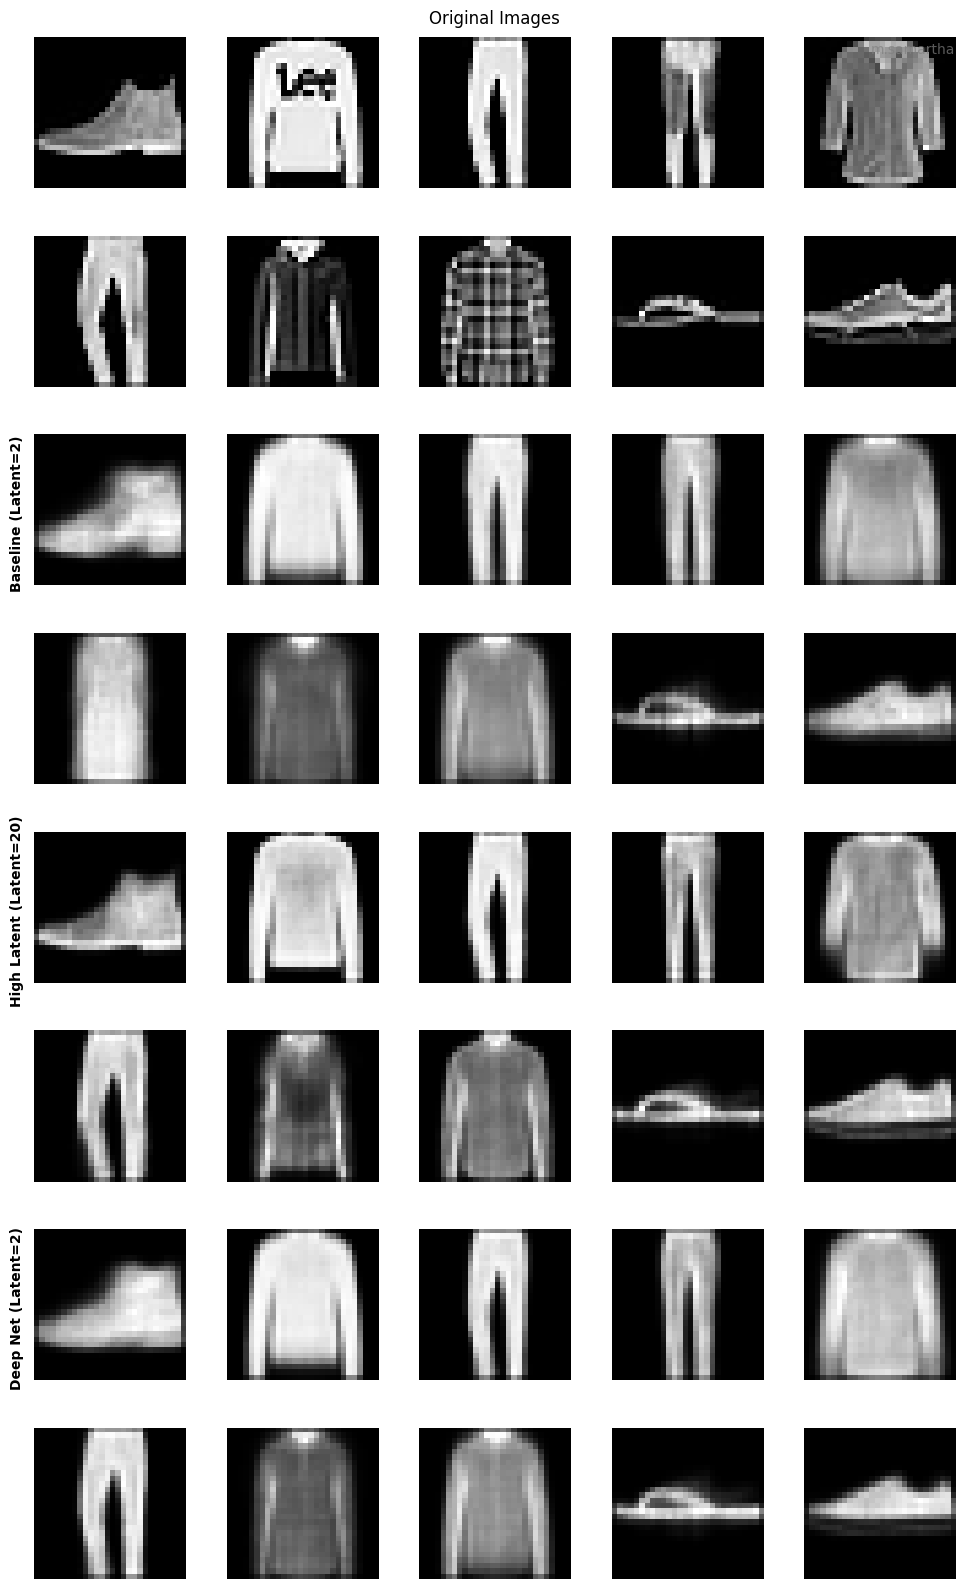

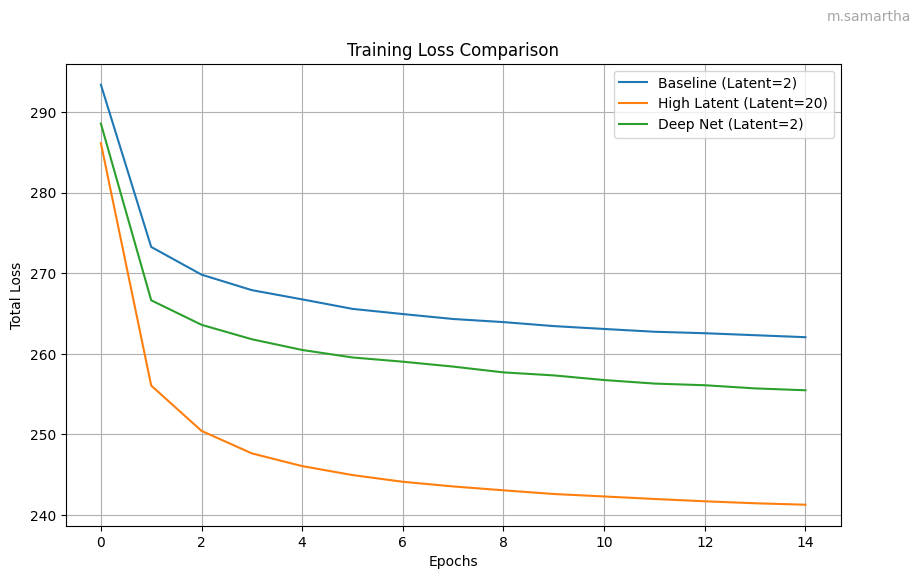

In [59]:
# 2. Visualize Reconstructions
visualize_comparative_reconstructions(trained_models, test_loader, num_images=10)

# 3. Plot Losses
plot_comparative_losses(loss_histories)

### Conclusion 
As seen from the reconstructions and loss plots, increasing the depth and latent dimension generally improves the reconstruction quality and reduces the loss. A deeper network can capture more complex features of the data, while a larger latent space allows for a richer representation of the input images. However, there is a trade-off between model complexity and overfitting, so it is important to choose these hyperparameters carefully based on the specific dataset and task. For more smoother latent space representations, deeper models with larger latent dimensions are preferred. They also naturally lead to higher fidelity reconstructions.

## 4.4 Loss Function

### Defined earlier in subsection 4.3
Here the loss term has two terms - reconstruction loss and KL divergence loss. The beta parameter controls the trade-off between these two losses. The former ensures that the reconstructed images are similar to the input images, while the latter regularizes the latent space to follow a standard normal distribution. Both of these are crucial for learning meaningful latent representations and generating new samples.

In [9]:
loss_function = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 4.5 Training the VAE

### Early stopping

In [10]:
class EarlyStopping:
    """
    Stops training if the loss doesn't improve after a given patience.
    """
    def __init__(self, patience=3, min_delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after last time loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

### Training Loop

In [12]:
class Trainer:
    """
    Handles the training loop, logging, plotting, and early stopping.
    """
    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        
        self.history = {
            'total_loss': [],
            'recon_loss': [],
            'kld_loss': []
        }

    def train_epoch(self, train_loader, epoch):
        self.model.train()
        train_loss = 0
        train_bce = 0
        train_kld = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            
            recon_batch, mu, logvar = self.model(data)
            loss, bce, kld = self.loss_fn(recon_batch, data, mu, logvar)
            
            loss.backward()
            train_loss += loss.item()
            train_bce += bce.item()
            train_kld += kld.item()
            self.optimizer.step()
            
        avg_loss = train_loss / len(train_loader.dataset)
        avg_bce = train_bce / len(train_loader.dataset)
        avg_kld = train_kld / len(train_loader.dataset)
        
        self.history['total_loss'].append(avg_loss)
        self.history['recon_loss'].append(avg_bce)
        self.history['kld_loss'].append(avg_kld)
        
        print(f'Epoch: {epoch} | Avg Loss: {avg_loss:.4f} | BCE: {avg_bce:.4f} | KLD: {avg_kld:.4f}')
        
        return avg_loss

    def fit(self, train_loader, epochs=10, patience=3):
        early_stopping = EarlyStopping(patience=patience, min_delta=0.1)
        
        for epoch in range(1, epochs + 1):
            epoch_loss = self.train_epoch(train_loader, epoch)
            
            # Check early stopping
            early_stopping(epoch_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
            
    def plot_losses(self):
        epochs = range(1, len(self.history['total_loss']) + 1)
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.history['total_loss'], label='Total Loss')
        plt.plot(epochs, self.history['recon_loss'], label='Reconstruction Loss (BCE)')
        plt.plot(epochs, self.history['kld_loss'], label='KL Divergence')
        plt.title('VAE Training Loss Components')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        add_username()
        plt.show()

    def visualize_reconstruction(self, test_loader, n=8):
        self.model.eval()
        with torch.no_grad():
            data, _ = next(iter(test_loader))
            data = data.to(self.device)
            recon, _, _ = self.model(data)
            
            data = data.view(-1, 28, 28).cpu()
            recon = recon.view(-1, 28, 28).cpu()
            
            fig, axes = plt.subplots(2, n, figsize=(n * 1.5, 3))
            for i in range(n):
                axes[0, i].imshow(data[i], cmap='gray')
                axes[0, i].axis('off')
                if i == n // 2: axes[0, i].set_title('Original')
                
                axes[1, i].imshow(recon[i], cmap='gray')
                axes[1, i].axis('off')
                if i == n // 2: axes[1, i].set_title('Reconstructed')
            add_username_fig(fig=fig)
            plt.show()

Epoch: 1 | Avg Loss: 288.6192 | BCE: 278.5291 | KLD: 10.0901
Epoch: 2 | Avg Loss: 254.4057 | BCE: 243.3073 | KLD: 11.0983
Epoch: 3 | Avg Loss: 248.6777 | BCE: 237.4440 | KLD: 11.2337
Epoch: 4 | Avg Loss: 246.0955 | BCE: 234.7535 | KLD: 11.3421
Epoch: 5 | Avg Loss: 244.6221 | BCE: 233.1674 | KLD: 11.4547
Epoch: 6 | Avg Loss: 243.4703 | BCE: 231.8761 | KLD: 11.5943
Epoch: 7 | Avg Loss: 242.5313 | BCE: 230.7017 | KLD: 11.8296
Epoch: 8 | Avg Loss: 241.7480 | BCE: 229.7458 | KLD: 12.0021
Epoch: 9 | Avg Loss: 241.1115 | BCE: 228.9506 | KLD: 12.1609
Epoch: 10 | Avg Loss: 240.5708 | BCE: 228.3055 | KLD: 12.2652
Epoch: 11 | Avg Loss: 240.1034 | BCE: 227.7446 | KLD: 12.3588
Epoch: 12 | Avg Loss: 239.7941 | BCE: 227.3447 | KLD: 12.4495
Epoch: 13 | Avg Loss: 239.3734 | BCE: 226.8717 | KLD: 12.5017
Epoch: 14 | Avg Loss: 239.0915 | BCE: 226.5459 | KLD: 12.5456
Epoch: 15 | Avg Loss: 238.8734 | BCE: 226.2624 | KLD: 12.6109
Epoch: 16 | Avg Loss: 238.6470 | BCE: 226.0053 | KLD: 12.6417
Epoch: 17 | Avg L

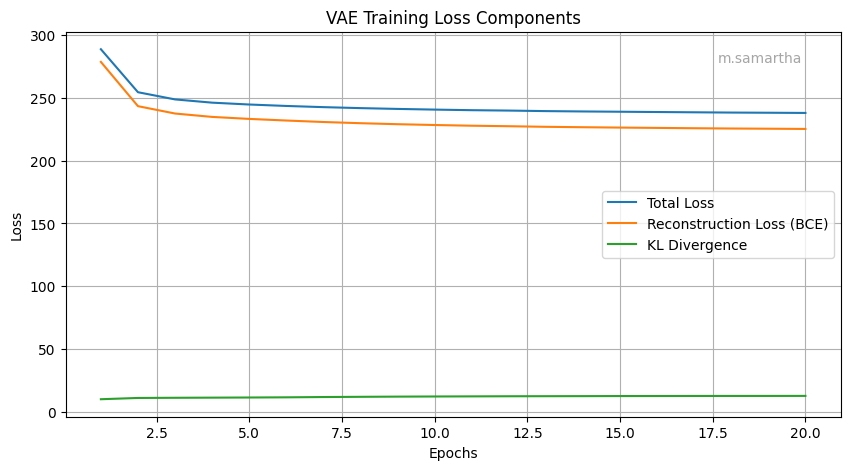

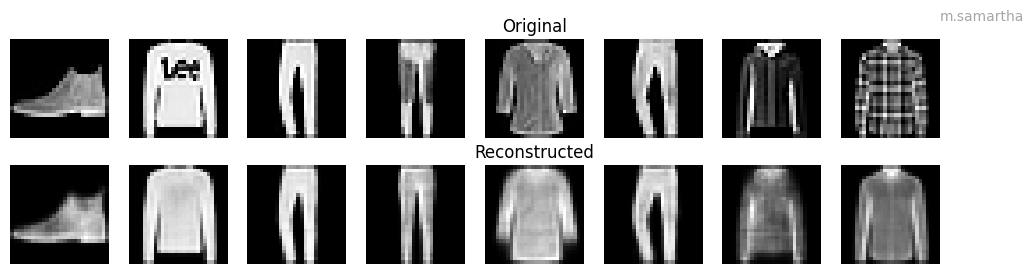

In [13]:
trainer = Trainer(model, optimizer, loss_function, device)
trainer.fit(train_loader, epochs=20, patience=5) 
trainer.plot_losses()
trainer.visualize_reconstruction(test_loader)

## 4.6 Experimental Analysis

In [ ]:
class BetaVAELoss:
    """
    Computes the VAE loss with a beta parameter weighting the KL Divergence.
    L = Reconstruction_Loss + beta * KL_Divergence
    """
    def __call__(self, recon_x, x, mu, logvar, beta=1.0):
        x = x.view(-1, 784)
        
        # Reconstruction Loss (BCE)
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        
        # KL Divergence
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return BCE + beta * KLD, BCE, KLD

class LatentVisualizer:
    """
    Helper class to visualize latent space and create GIFs.
    """
    def __init__(self, model, test_loader, device, specific_classes=[0, 1, 2]):
        """
        Args:
            specific_classes (list): List of 3 class indices to visualize. 
                                     (e.g., 0:T-shirt, 1:Trouser, 2:Pullover)
        """
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.classes = specific_classes
        self.class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        self.plots = [] # Store file paths of plots for GIF

    def get_latent_embeddings(self):
        self.model.eval()
        embeddings = []
        labels = []
        
        with torch.no_grad():
            for data, target in self.test_loader:
                data = data.to(self.device)
                mu, _ = self.model.encoder(data.view(-1, 784))
                embeddings.append(mu.cpu())
                labels.append(target)
                
        embeddings = torch.cat(embeddings).numpy()
        labels = torch.cat(labels).numpy()
        return embeddings, labels

    def plot_latent_space(self, epoch, beta, save_dir='plots'):
        """Plots latent space for specific classes and saves image."""
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        z, y = self.get_latent_embeddings()
        
        plt.figure(figsize=(8, 6))
        colors = ['r', 'g', 'b']
        
        # Filter and plot only the specific classes
        for i, class_idx in enumerate(self.classes):
            indices = np.where(y == class_idx)[0]
            # We only plot the first 2 dimensions of z (assuming latent_dim >= 2)
            # If latent_dim > 2, PCA or t-SNE is usually needed, but for observation 
            # in simple VAEs, taking first 2 dims is a common approximation during training
            # or if latent_dim was set to 2 explicitly.
            plt.scatter(z[indices, 0], z[indices, 1], c=colors[i], label=self.class_names[class_idx], alpha=0.5, s=10)
            
        plt.title(f'Latent Space (Epoch {epoch}, Beta={beta})')
        plt.legend()
        plt.grid(True)
        
        filename = f"{save_dir}/latent_epoch_{epoch}_beta_{beta}.png"
        plt.savefig(filename)
        add_username()
        plt.close()
        self.plots.append(filename)

    def create_gif(self, beta, save_path='latent_evolution.gif'):
        """Stitches saved plots into a GIF."""
        images = []
        for filename in self.plots:
            images.append(imageio.imread(filename))
        imageio.mimsave(save_path, images, duration=0.5) # 0.5 seconds per frame
        print(f"GIF saved to {save_path}")
        # Clean up old plots
        self.plots = []

### Experiment runner

In [17]:
def run_beta_experiment(betas=[0.1, 0.5, 1.0], epochs=10):
    # Assuming standard parameters
    input_dim = 784
    hidden_dim = 400
    latent_dim = 2 # Set to 2 for easy 2D visualization without t-SNE
    
    results = {} # To store metrics for the table

    for beta in betas:
        print(f"--- Running Experiment with Beta = {beta} ---")
        
        # 1. Initialize fresh model
        model = VAE(input_dim, hidden_dim, latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = BetaVAELoss()
        
        # 2. Visualizer
        # Picking classes: 0 (T-shirt), 1 (Trouser), 7 (Sneaker) for distinct shapes
        visualizer = LatentVisualizer(model, test_loader, device, specific_classes=[0, 1, 7])
        
        # 3. Training Loop
        model.train()
        final_recon_loss = 0
        
        for epoch in range(1, epochs + 1):
            total_loss = 0
            recon_accum = 0
            
            for batch_idx, (data, _) in enumerate(train_loader):
                data = data.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = model(data)
                loss, bce, kld = loss_fn(recon_batch, data, mu, logvar, beta=beta)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                recon_accum += bce.item()
            
            avg_recon = recon_accum / len(train_loader.dataset)
            print(f"Epoch {epoch} | Beta {beta} | Recon Loss: {avg_recon:.4f}")
            
            # Save snapshot for GIF
            visualizer.plot_latent_space(epoch, beta)
            
            if epoch == epochs:
                final_recon_loss = avg_recon

        # Create GIF for this beta
        visualizer.create_gif(beta, save_path=f'latent_evolution_beta_{beta}.gif')
        
        # Store results
        results[beta] = final_recon_loss

    print("\n--- Summary Table ---")
    print(f"{'Beta':<10} | {'Reconstruction Loss':<20}")
    print("-" * 35)
    for b, loss in results.items():
        print(f"{b:<10} | {loss:.4f}")

In [18]:
run_beta_experiment(betas=[0.1, 0.5, 1.0], epochs=20) 

--- Running Experiment with Beta = 0.1 ---
Epoch 1 | Beta 0.1 | Recon Loss: 280.9565
Epoch 2 | Beta 0.1 | Recon Loss: 258.9293
Epoch 3 | Beta 0.1 | Recon Loss: 255.6381
Epoch 4 | Beta 0.1 | Recon Loss: 253.8201
Epoch 5 | Beta 0.1 | Recon Loss: 252.5458
Epoch 6 | Beta 0.1 | Recon Loss: 251.5429
Epoch 7 | Beta 0.1 | Recon Loss: 250.7517
Epoch 8 | Beta 0.1 | Recon Loss: 250.2238
Epoch 9 | Beta 0.1 | Recon Loss: 249.6654
Epoch 10 | Beta 0.1 | Recon Loss: 249.3067
Epoch 11 | Beta 0.1 | Recon Loss: 248.9449
Epoch 12 | Beta 0.1 | Recon Loss: 248.4622
Epoch 13 | Beta 0.1 | Recon Loss: 247.9538
Epoch 14 | Beta 0.1 | Recon Loss: 247.5770
Epoch 15 | Beta 0.1 | Recon Loss: 247.1429
Epoch 16 | Beta 0.1 | Recon Loss: 247.1550
Epoch 17 | Beta 0.1 | Recon Loss: 246.7033
Epoch 18 | Beta 0.1 | Recon Loss: 246.4416
Epoch 19 | Beta 0.1 | Recon Loss: 246.4851
Epoch 20 | Beta 0.1 | Recon Loss: 246.2976


/tmp/ipykernel_153089/1562432435.py:84: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved to latent_evolution_beta_0.1.gif
--- Running Experiment with Beta = 0.5 ---
Epoch 1 | Beta 0.5 | Recon Loss: 282.8754
Epoch 2 | Beta 0.5 | Recon Loss: 259.5511
Epoch 3 | Beta 0.5 | Recon Loss: 256.3102
Epoch 4 | Beta 0.5 | Recon Loss: 254.5979
Epoch 5 | Beta 0.5 | Recon Loss: 253.2981
Epoch 6 | Beta 0.5 | Recon Loss: 252.2373
Epoch 7 | Beta 0.5 | Recon Loss: 251.6975
Epoch 8 | Beta 0.5 | Recon Loss: 251.0214
Epoch 9 | Beta 0.5 | Recon Loss: 250.2999
Epoch 10 | Beta 0.5 | Recon Loss: 249.8284
Epoch 11 | Beta 0.5 | Recon Loss: 249.3530
Epoch 12 | Beta 0.5 | Recon Loss: 248.8924
Epoch 13 | Beta 0.5 | Recon Loss: 248.4623
Epoch 14 | Beta 0.5 | Recon Loss: 248.1605
Epoch 15 | Beta 0.5 | Recon Loss: 247.7566
Epoch 16 | Beta 0.5 | Recon Loss: 247.4188
Epoch 17 | Beta 0.5 | Recon Loss: 247.2306
Epoch 18 | Beta 0.5 | Recon Loss: 247.1080
Epoch 19 | Beta 0.5 | Recon Loss: 246.9950
Epoch 20 | Beta 0.5 | Recon Loss: 246.4731
GIF saved to latent_evolution_beta_0.5.gif
--- Running Experime

In [24]:
class LatentVisualizerImage:
    """
    Helper class to visualize latent space with overlayed images and create GIFs.
    """
    def __init__(self, model, test_loader, device, specific_classes=[0, 1, 2]):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.classes = specific_classes
        self.class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        self.plots = [] 

    def get_latent_embeddings(self):
        """
        Returns embeddings, labels, AND original images.
        """
        self.model.eval()
        embeddings = []
        labels = []
        images = []
        
        with torch.no_grad():
            for data, target in self.test_loader:
                data = data.to(self.device)
                mu, _ = self.model.encoder(data.view(-1, 784))
                
                embeddings.append(mu.cpu())
                labels.append(target.cpu())
                # Store original images for visualization
                images.append(data.cpu()) 
                
        embeddings = torch.cat(embeddings).numpy()
        labels = torch.cat(labels).numpy()
        images = torch.cat(images).numpy()
        return embeddings, labels, images

    def plot_latent_space(self, epoch, beta, save_dir='plots'):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        z, y, imgs = self.get_latent_embeddings()
        
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = ['r', 'g', 'b']
        
        # Filter and plot only the specific classes
        for i, class_idx in enumerate(self.classes):
            indices = np.where(y == class_idx)[0]
            
            # 1. Scatter Plot (The dots)
            ax.scatter(z[indices, 0], z[indices, 1], c=colors[i], 
                       label=self.class_names[class_idx], alpha=0.2, s=10)
            
            # 2. Image Overlay (The actual images)
            # Select 10 random images per class to display
            num_overlays = 10
            if len(indices) > num_overlays:
                # Randomly choose indices without replacement
                overlay_indices = np.random.choice(indices, num_overlays, replace=False)
            else:
                overlay_indices = indices
                
            for idx in overlay_indices:
                # Get the image (1, 28, 28) -> (28, 28)
                img_data = imgs[idx].squeeze()
                
                # Create an image box
                # zoom=0.5 scales the image down so it doesn't cover the whole plot
                im = OffsetImage(img_data, zoom=0.7, cmap='gray_r') 
                
                # Place it at the latent coordinate (z[0], z[1])
                ab = AnnotationBbox(im, (z[idx, 0], z[idx, 1]), xycoords='data', frameon=False)
                ax.add_artist(ab)
            
        ax.set_title(f'Latent Space with Image Overlays (Epoch {epoch}, Beta={beta})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        filename = f"{save_dir}/latent_epoch_{epoch}_beta_{beta}.png"
        add_username()
        plt.savefig(filename)
        plt.close()
        self.plots.append(filename)

    def create_gif(self, beta, save_path=None):
        if save_path is None:
            save_path = f'latent_evolution_w_image_beta_{beta}.gif'
            
        images = []
        for filename in self.plots:
            images.append(imageio.imread(filename))
        imageio.mimsave(save_path, images, duration=0.5)
        print(f"GIF saved to {save_path}")
        self.plots = []

In [26]:
def run_beta_experiment(betas=[0.1, 0.5, 1.0], epochs=20):
    # Assuming standard parameters
    input_dim = 784
    hidden_dim = 400
    latent_dim = 2 # Set to 2 for easy 2D visualization
    
    results = {} 

    for beta in betas:
        print(f"--- Running Experiment with Beta = {beta} ---")
        
        # 1. Initialize fresh model
        model = VAE(input_dim, hidden_dim, latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = BetaVAELoss()
        
        # 2. Visualizer
        # Classes: 0 (T-shirt), 1 (Trouser), 7 (Sneaker)
        visualizer = LatentVisualizerImage(model, test_loader, device, specific_classes=[0, 1, 7])
        
        # 3. Training Loop
        model.train()
        final_recon_loss = 0
        
        for epoch in range(1, epochs + 1):
            total_loss = 0
            recon_accum = 0
            
            for batch_idx, (data, _) in enumerate(train_loader):
                data = data.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = model(data)
                loss, bce, kld = loss_fn(recon_batch, data, mu, logvar, beta=beta)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                recon_accum += bce.item()
            
            avg_recon = recon_accum / len(train_loader.dataset)
            print(f"Epoch {epoch} | Beta {beta} | Recon Loss: {avg_recon:.4f}")
            
            # Save snapshot for GIF
            visualizer.plot_latent_space(epoch, beta)
            
            if epoch == epochs:
                final_recon_loss = avg_recon

        # Create GIF for this beta
        visualizer.create_gif(beta)
        
        # Store results
        results[beta] = final_recon_loss

    print("\n--- Summary Table ---")
    print(f"{'Beta':<10} | {'Reconstruction Loss':<20}")
    print("-" * 35)
    for b, loss in results.items():
        print(f"{b:<10} | {loss:.4f}")

In [27]:
run_beta_experiment(betas=[0.1, 0.5, 1.0], epochs=20)

--- Running Experiment with Beta = 0.1 ---
Epoch 1 | Beta 0.1 | Recon Loss: 280.5285
Epoch 2 | Beta 0.1 | Recon Loss: 258.7510
Epoch 3 | Beta 0.1 | Recon Loss: 255.4019
Epoch 4 | Beta 0.1 | Recon Loss: 253.8625
Epoch 5 | Beta 0.1 | Recon Loss: 252.6899
Epoch 6 | Beta 0.1 | Recon Loss: 251.7730
Epoch 7 | Beta 0.1 | Recon Loss: 251.2646
Epoch 8 | Beta 0.1 | Recon Loss: 250.4137
Epoch 9 | Beta 0.1 | Recon Loss: 250.0393
Epoch 10 | Beta 0.1 | Recon Loss: 249.7383
Epoch 11 | Beta 0.1 | Recon Loss: 249.4059
Epoch 12 | Beta 0.1 | Recon Loss: 248.7756
Epoch 13 | Beta 0.1 | Recon Loss: 248.1694
Epoch 14 | Beta 0.1 | Recon Loss: 248.3512
Epoch 15 | Beta 0.1 | Recon Loss: 247.6163
Epoch 16 | Beta 0.1 | Recon Loss: 247.2092
Epoch 17 | Beta 0.1 | Recon Loss: 247.1495
Epoch 18 | Beta 0.1 | Recon Loss: 247.3019
Epoch 19 | Beta 0.1 | Recon Loss: 247.3202
Epoch 20 | Beta 0.1 | Recon Loss: 246.8597


/tmp/ipykernel_153089/1504180190.py:92: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved to latent_evolution_w_image_beta_0.1.gif
--- Running Experiment with Beta = 0.5 ---
Epoch 1 | Beta 0.5 | Recon Loss: 280.8407
Epoch 2 | Beta 0.5 | Recon Loss: 259.5280
Epoch 3 | Beta 0.5 | Recon Loss: 256.3180
Epoch 4 | Beta 0.5 | Recon Loss: 254.5141
Epoch 5 | Beta 0.5 | Recon Loss: 252.9560
Epoch 6 | Beta 0.5 | Recon Loss: 252.1568
Epoch 7 | Beta 0.5 | Recon Loss: 251.3636
Epoch 8 | Beta 0.5 | Recon Loss: 250.9867
Epoch 9 | Beta 0.5 | Recon Loss: 250.3939
Epoch 10 | Beta 0.5 | Recon Loss: 249.9140
Epoch 11 | Beta 0.5 | Recon Loss: 249.3631
Epoch 12 | Beta 0.5 | Recon Loss: 249.0126
Epoch 13 | Beta 0.5 | Recon Loss: 248.6397
Epoch 14 | Beta 0.5 | Recon Loss: 248.2935
Epoch 15 | Beta 0.5 | Recon Loss: 248.1303
Epoch 16 | Beta 0.5 | Recon Loss: 247.3864
Epoch 17 | Beta 0.5 | Recon Loss: 247.1386
Epoch 18 | Beta 0.5 | Recon Loss: 248.1470
Epoch 19 | Beta 0.5 | Recon Loss: 247.1000
Epoch 20 | Beta 0.5 | Recon Loss: 247.7059
GIF saved to latent_evolution_w_image_beta_0.5.gif
--- 

### Conclusions on effect of beta (mixing ratio of the losses)
We have the following results for different beta values:

- Beta = 0.1: Loss = 246.8597
- Beta = 0.5: Loss = 247.7059
- Beta = 1.0: Loss = 248.7321

We see that the losses are quite similar across different beta values. This is because of the scale of the individual loss components. The reconstruction loss is typically much larger in magnitude compared to the KL divergence term. As a result, even with different beta values, the overall loss remains dominated by the reconstruction loss. 

Further, as seen from the GIFs of the latent space evolution, with lower beta values, even though the clustering is evident, the latent space appears more scattered. As we increase beta, the latent space becomes more structured and well-defined clusters emerge. This indicates that a higher beta encourages the model to learn a more organized latent representation, which can be beneficial for generating diverse and meaningful samples.

## 4.7 Evaluation and Visualization

In [31]:
try:
    from torchmetrics.image.fid import FrechetInceptionDistance
except ImportError:
    print("Install torchmetrics using: pip install torchmetrics[image]")

def evaluate_model(model, test_loader, num_samples=16):
    model.eval()
    
    # 1. Reconstruction (Side-by-Side)
    data, _ = next(iter(test_loader))
    data = data.to(device)
    with torch.no_grad():
        recon, _, _ = model(data)
    
    # Plot Original vs Reconstructed
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        # Original
        axes[0, i].imshow(data[i].cpu().view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Orig")
        # Reconstructed
        axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Recon")
    plt.suptitle("Reconstruction Quality")
    add_username_fig(fig=fig)
    plt.show()
    
    # 2. Generation from N(0, I)
    latent_dim = model.encoder.fc_mu.out_features
    print(f"Generating samples using latent_dim={latent_dim}")
    
    z = torch.randn(num_samples, latent_dim).to(device) 
    
    with torch.no_grad():
        generated = model.decoder(z).cpu().view(-1, 28, 28)
        
    plt.figure(figsize=(8, 8))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Generated Samples (Latent Dim: {latent_dim})")
    add_username()
    plt.show()

def calculate_fid_batched(model, test_loader, num_samples=1000, batch_size=32, device='cuda'):
    """
    Calculates FID score using batch processing to avoid CUDA OOM errors.
    """
    print(f"Calculating FID Score on {num_samples} samples (Batch size: {batch_size})...")
    
    # Initialize FID metric
    # feature=64 is lighter; use 2048 for standard academic comparison if memory allows
    fid = FrechetInceptionDistance(feature=64).to(device)
    
    # Clear cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    model.eval()
    
    # --- 1. Process REAL Images in Batches ---
    print("Processing Real Images...")
    current_samples = 0
    
    for data, _ in test_loader:
        if current_samples >= num_samples:
            break
            
        # Adjust batch size if we are near the limit
        remaining = num_samples - current_samples
        if data.shape[0] > remaining:
            data = data[:remaining]
            
        data = data.to(device)
        
        # Convert to RGB (3 channels) and uint8 [0, 255]
        # FashionMNIST is 1 channel -> repeat to 3
        real_rgb = data.repeat(1, 3, 1, 1)
        real_uint8 = (real_rgb * 255).byte()
        
        # Update FID stats incrementally
        fid.update(real_uint8, real=True)
        
        current_samples += data.shape[0]
        
        # explicit delete to free memory immediately
        del data, real_rgb, real_uint8

    # --- 2. Process FAKE Images in Batches ---
    print("Processing Fake Images...")
    latent_dim = model.encoder.fc_mu.out_features
    current_samples = 0
    
    while current_samples < num_samples:
        # Determine batch size
        current_batch_size = min(batch_size, num_samples - current_samples)
        
        # Generate latent vectors
        z = torch.randn(current_batch_size, latent_dim).to(device)
        
        with torch.no_grad():
            fake_images = model.decoder(z)
        
        # Convert to RGB and uint8
        fake_rgb = fake_images.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
        fake_uint8 = (fake_rgb * 255).byte()
        
        # Update FID stats incrementally
        fid.update(fake_uint8, real=False)
        
        current_samples += current_batch_size
        
        # explicit delete
        del z, fake_images, fake_rgb, fake_uint8
    
    # Compute final score
    score = fid.compute()
    print(f"FID Score: {score.item():.4f}")
    return score.item()

### Evaluate and calculate FID

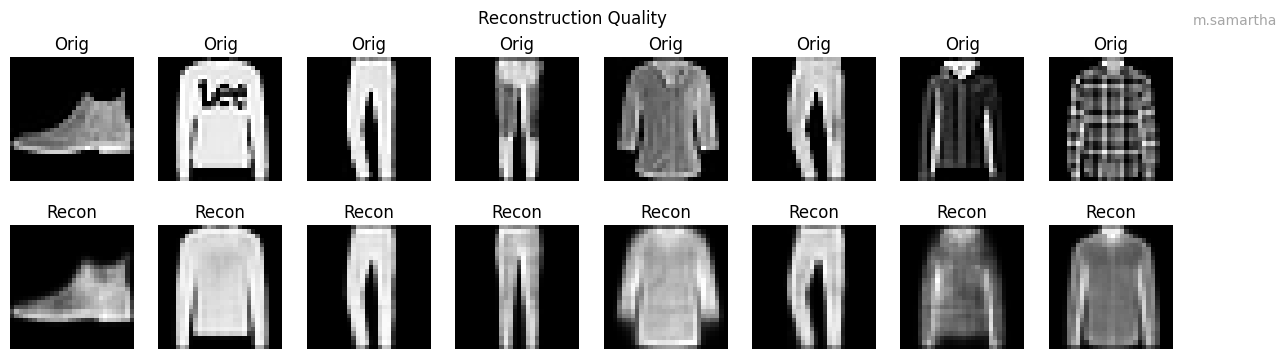

Generating samples using latent_dim=20


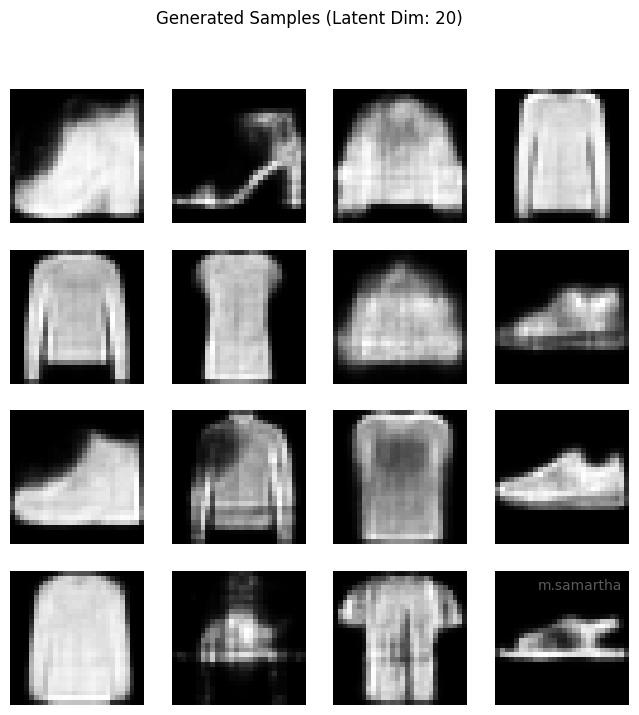

Calculating FID Score on 10000 samples (Batch size: 32)...
Processing Real Images...
Processing Fake Images...
FID Score: 0.3027


In [32]:
evaluate_model(model, test_loader)
score = calculate_fid_batched(model, test_loader, num_samples=10000, batch_size=32, device=device)

### Conclusions on evaluations and FID
We see that the reconstruction quality is good enough and the similarity between the original and reconstructed images is visually apparent. The FID score is calculated over 10,000 samples and provides a quantitative measure of the quality of the generated images. A lower FID score indicates that the generated images are closer to the real images in terms of distribution.

We obtain a `FID score of 0.3027`, which is quite low, indicating that the VAE has learned to generate images that are very similar to the real images in the dataset. This suggests that the model has effectively captured the underlying data distribution and is capable of producing high-quality reconstructions.

## 4.8 Effect of Frozen Latent Parameters

In [45]:
def experiment_frozen_latents(model):
    """
    Investigate influence of fixed mean (mu=0) and varying sigma (std).
    """
    model.eval()
    latent_dim = model.encoder.fc_mu.out_features
    sigmas = [0.1, 0.5, 1.0]
    
    plt.figure(figsize=(10, 6))
    
    num_images = 8
    rows_per_sigma = 2
    cols_per_sigma = num_images // 2   # 4 images per row

    fig = plt.figure(figsize=(cols_per_sigma * 2, len(sigmas) * 4))

    for i, sigma in enumerate(sigmas):
        # Freeze mu = 0, vary sigma
        epsilon = torch.randn(16, latent_dim).to(device)
        z = epsilon * sigma
        
        with torch.no_grad():
            generated = model.decoder(z).cpu().view(-1, 28, 28)

        # Create 2×4 grid **within each sigma**
        for j in range(num_images):
            row_in_sigma = j // cols_per_sigma    # 0 or 1
            col_in_sigma = j % cols_per_sigma     # 0..3

            # Global position in the full figure
            ax_index = (
                i * num_images       # skip previous sigma blocks
                + j
                + 1
            )

            ax = fig.add_subplot(len(sigmas) * rows_per_sigma,
                                cols_per_sigma,
                                ax_index)

            ax.imshow(generated[j], cmap='gray')
            ax.axis('off')

            # Title only on the first image of each sigma block
            if j == 0:
                ax.set_title(f"Sigma = {sigma}")

    plt.suptitle("Generation with Frozen Mu=0, Varying Sigma")
    plt.tight_layout()
    add_username_fig(fig=plt.gcf())
    plt.show()

<Figure size 1000x600 with 0 Axes>

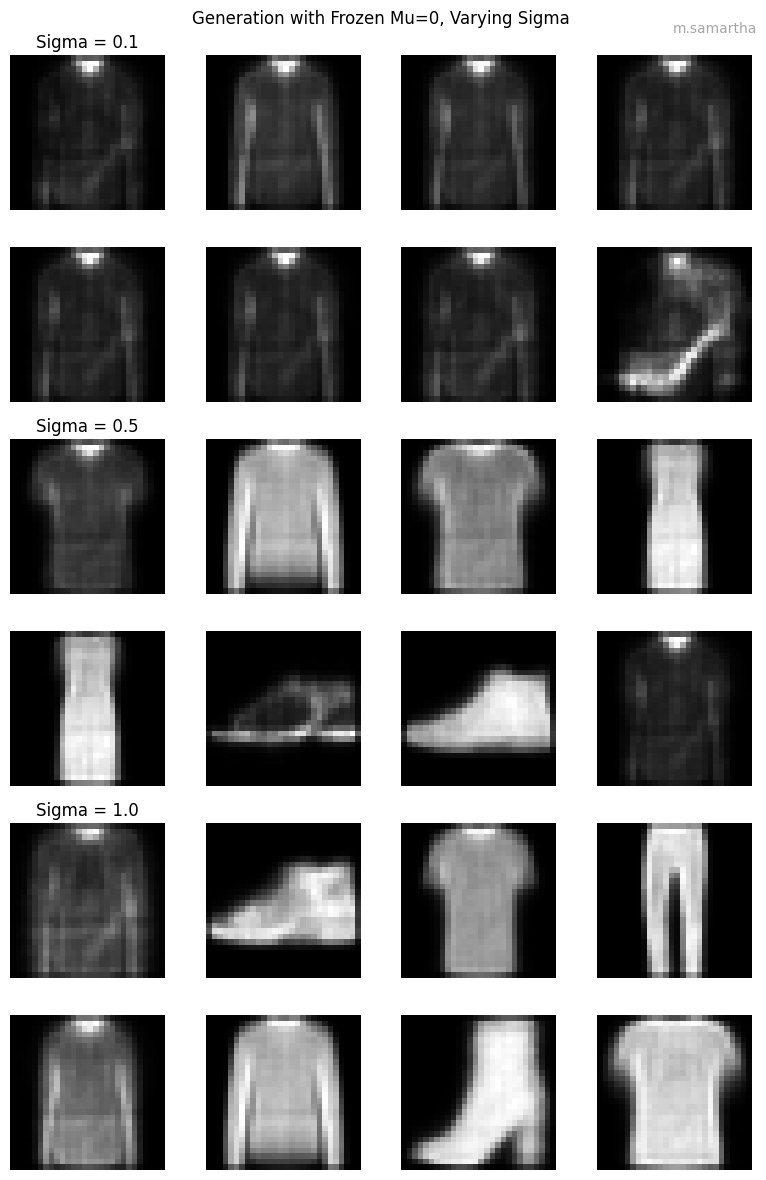

In [46]:
experiment_frozen_latents(model)

### Conclusions on effect of frozen latent parameters
As we see from the image above, we are varying the standard deviation (sigma) while keeping the mean (mu) fixed at 0. 

When sigma is very small (0.1), the generated images are quite similar to each other, indicating `low diversity`. As we increase sigma to 0.5 and then to 1.0, the diversity of the generated images increases significantly. The images become more `varied and distinct` from one another. This suggests that a higher standard deviation allows the model to explore a wider range of the latent space, leading to more diverse outputs. Thus the **representation is more smooth and varied with higher sigma values**.

Say, we fix sigma and vary mu instead, we would observe a similar trend where varying mu would shift the generated images in different directions in the latent space, leading to diverse outputs as well. **The location parameter (mu) essentially determines the center of the distribution from which we sample**, so changing it would also affect the diversity and characteristics of the generated images.